<a href="https://colab.research.google.com/github/shahchayan9/Dimensionality-Reduction/blob/main/Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AutoEncoder

## Overview
AutoEncoder is an unsupervised Artificial Neural Network that attempts to encode the data by compressing it into the lower dimensions (bottleneck layer or code) and then decoding the data to reconstruct the original input. The bottleneck layer (or code) holds the compressed representation of the input data.

In AutoEncoder, the number of output units must be equal to the number of input units since we’re attempting to reconstruct the input data. AutoEncoders usually consist of an **encoder** and a **decoder**:
- **Encoder**: Encodes the provided data into a lower dimension which is the size of the bottleneck layer.
- **Decoder**: Decodes the compressed data into its original form.

---

## Characteristics of Encoder and Decoder
- The number of neurons in the layers of the **encoder** decreases as we move through subsequent layers.
- The number of neurons in the layers of the **decoder** increases as we move through subsequent layers.

### Example Architecture:
- **Encoder**:
  - Layer 1: 32 units
  - Layer 2: 16 units
  - Layer 3: 7 units (bottleneck layer)
- **Decoder**:
  - Layer 1: 7 units
  - Layer 2: 16 units
  - Layer 3: 32 units

**Note:** The bottleneck layer (code size) must have fewer neurons than the number of features in the input data.

---

## Data Preparation
Before feeding the data into the AutoEncoder, it must be scaled between 0 and 1 using `MinMaxScaler`. This is important because we use the sigmoid activation function in the output layer, which outputs values between 0 and 1.

---

## Use in Dimensionality Reduction
When using AutoEncoders for dimensionality reduction:
- Extract the bottleneck layer.
- Use the bottleneck layer to reduce the dimensions of the input data.
- This process is often referred to as **feature extraction**.

---

## Type of AutoEncoder
The type of AutoEncoder we’re discussing is the **Deep AutoEncoder**, where the encoder and decoder are symmetrical. However, AutoEncoders can also have non-symmetrical encoder and decoder architectures.

### Other Types of AutoEncoders:
1. **Deep AutoEncoder**
2. **Sparse AutoEncoder**
3. **Undercomplete AutoEncoder**
4. **Variational AutoEncoder**
5. **LSTM AutoEncoder**

---

## Hyperparameters of an AutoEncoder
1. **Code size**: The number of units in the bottleneck layer.
2. **Input and output size**: Number of features in the data.
3. **Number of neurons**: Nodes per layer in the encoder and decoder.
4. **Number of layers**: Layers in the encoder and decoder.
5. **Activation function**
6. **Optimization function**

## Applications of AutoEncoders

AutoEncoders have diverse applications across various domains, including but not limited to:

1. **Dimensionality Reduction**  
   - Extract the bottleneck layer to reduce the dimensionality of data.  
   - Commonly used for feature extraction and visualization.

2. **Anomaly Detection**  
   - Train the AutoEncoder on normal data, then detect anomalies by identifying data points with high reconstruction error.  
   - Widely applied in fraud detection, network security, and system monitoring.

3. **Image Denoising**  
   - Remove noise from images by training the AutoEncoder to reconstruct clean images from noisy inputs.

4. **Image Compression**  
   - Compress images into a lower-dimensional representation and reconstruct them when needed, reducing storage and transmission requirements.

5. **Image Generation**  
   - Generate new images by leveraging the latent space representation in combination with techniques like Variational AutoEncoders (VAEs).




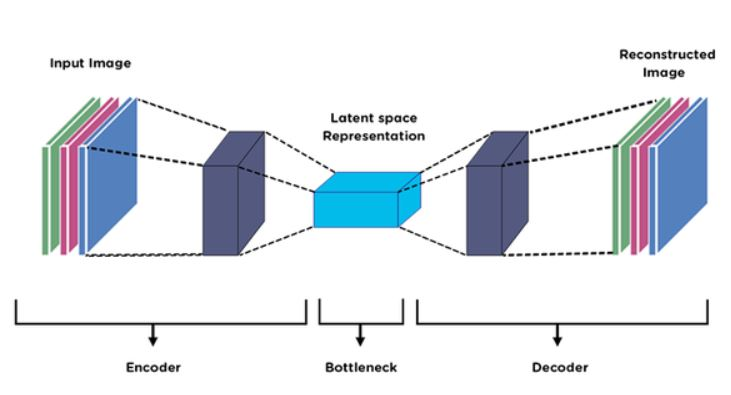

In [ ]:
from IPython.display import Image, display

display(Image('/content/Autoencoder.jpg'))

#Dimensionality Reduction using AutoEncoders

In [ ]:
!pip install pandas tensorflow keras-tuner matplotlib scikit-learn > /dev/null

Import the required libraries and split the data for training and testing.

In [ ]:
import math
import pandas as pd
import tensorflow as tf
import kerastuner.tuners as kt
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError

In [ ]:
# data in google colab
TRAIN_DATA_PATH = '/content/sample_data/california_housing_train.csv'
TEST_DATA_PATH = '/content/sample_data/california_housing_test.csv'
TARGET_NAME = 'median_house_value'

train_data = pd.read_csv(TRAIN_DATA_PATH)
test_data = pd.read_csv(TEST_DATA_PATH)

x_train, y_train = train_data.drop(TARGET_NAME, axis=1), train_data[TARGET_NAME]
x_test, y_test = test_data.drop(TARGET_NAME, axis=1), test_data[TARGET_NAME]

In [ ]:
x_train

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250
...,...,...,...,...,...,...,...,...
16995,-124.26,40.58,52.0,2217.0,394.0,907.0,369.0,2.3571
16996,-124.27,40.69,36.0,2349.0,528.0,1194.0,465.0,2.5179
16997,-124.30,41.84,17.0,2677.0,531.0,1244.0,456.0,3.0313
16998,-124.30,41.80,19.0,2672.0,552.0,1298.0,478.0,1.9797


Scale the dataset using MinMaxScaler.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def scale_datasets(x_train, x_test):
  """
  Standard Scale test and train data
  """
  standard_scaler = MinMaxScaler()
  x_train_scaled = pd.DataFrame(
      standard_scaler.fit_transform(x_train),
      columns=x_train.columns
  )
  x_test_scaled = pd.DataFrame(
      standard_scaler.transform(x_test),
      columns = x_test.columns
  )
  return x_train_scaled, x_test_scaled

x_train_scaled, x_test_scaled = scale_datasets(x_train, x_test)

Train the autoencoder with the training data.

In [ ]:
class AutoEncoders(Model):

  def __init__(self, output_units):

    super().__init__()
    self.encoder = Sequential(
        [
          Dense(32, activation="relu"),
          Dense(16, activation="relu"),
          Dense(7, activation="relu")
        ]
    )

    self.decoder = Sequential(
        [
          Dense(16, activation="relu"),
          Dense(32, activation="relu"),
          Dense(output_units, activation="sigmoid")
        ]
    )

  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded



In [ ]:


auto_encoder = AutoEncoders(len(x_train_scaled.columns))

auto_encoder.compile(
    loss='mae',
    metrics=['mae'],
    optimizer='adam'
)

history = auto_encoder.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=15,
    batch_size=32,
    validation_data=(x_test_scaled, x_test_scaled)
)

Epoch 1/15
532/532 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1438 - mae: 0.1438 - val_loss: 0.0288 - val_mae: 0.0288
Epoch 2/15
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0280 - mae: 0.0280 - val_loss: 0.0254 - val_mae: 0.0254
Epoch 3/15
532/532 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0257 - mae: 0.0257 - val_loss: 0.0242 - val_mae: 0.0242
Epoch 4/15
532/532 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0242 - mae: 0.0242 - val_loss: 0.0229 - val_mae: 0.0229
Epoch 5/15
532/532 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0231 - mae: 0.0231 - val_loss: 0.0205 - val_mae: 0.0205
Epoch 6/15
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0182 - mae: 0.0182 - val_loss: 0.0148 - val_mae: 0.0148
Epoch 7/15
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0135 - mae: 0.0135 - val_loss: 0.0133 - val_mae: 0.0133
Epoch 8/15
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0130 - mae: 0.0130 - val_loss: 0.0131 - val_mae: 0.0131
Epoch 9/15
532/532 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

Here we have defined the autoencoder model by subclassing the Model class in Tensorflow and we compile the AutoEncoder model with mean absolute error and adam optimization function. We split the data into batches of 32 and we run it for 15 epochs.

Get the encoder layer and use the method predict to reduce dimensions in data. Since we have seven hidden units in the bottleneck the data is reduced to seven features.

In [ ]:
# Access the encoder layer by its correct name 'sequential_3'
encoder_layer = auto_encoder.get_layer('sequential_2')
reduced_df = pd.DataFrame(encoder_layer.predict(x_train_scaled))
reduced_df = reduced_df.add_prefix('feature_')

532/532 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [ ]:
reduced_df

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6
0,1.910189,0.793701,0.0,0.0,1.370486,0.0,0.348154
1,1.696976,0.854430,0.0,0.0,1.216591,0.0,0.253306
2,2.593221,1.540414,0.0,0.0,1.973768,0.0,0.836972
3,2.433524,1.406124,0.0,0.0,1.453211,0.0,0.854276
4,2.314565,1.429179,0.0,0.0,1.686341,0.0,0.596433
...,...,...,...,...,...,...,...
16995,0.020981,1.907994,0.0,0.0,1.711836,0.0,1.059268
16996,0.161980,1.287565,0.0,0.0,1.591794,0.0,1.260168
16997,0.382531,0.697428,0.0,0.0,1.598031,0.0,1.736182
16998,0.312016,0.611585,0.0,0.0,1.736373,0.0,1.600737


In this way, AutoEncoders can be used to reduce dimensions in data.

# Auto encoder applications with Image dataset

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

## Load the dataset
To start, you will train the basic autoencoder using the Fashion MNIST dataset. Each image in this dataset is 28x28 pixels.

In [ ]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


## First example: Basic autoencoder

Define an autoencoder with two Dense layers: an `encoder`, which compresses the images into a 64 dimensional latent vector, and a `decoder`, that reconstructs the original image from the latent space.

To define your model, use the [Keras Model Subclassing API](https://www.tensorflow.org/guide/keras/custom_layers_and_models).


In [ ]:
class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(tf.math.reduce_prod(shape).numpy(), activation='sigmoid'),
      layers.Reshape(shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


shape = x_test.shape[1:]
latent_dim = 64
autoencoder = Autoencoder(latent_dim, shape)


In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

Train the model using `x_train` as both the input and the target. The `encoder` will learn to compress the dataset from 784 dimensions to the latent space, and the `decoder` will learn to reconstruct the original images.
.

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0396 - val_loss: 0.0134
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0124 - val_loss: 0.0107
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0104 - val_loss: 0.0099
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0097 - val_loss: 0.0095
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0094 - val_loss: 0.0093
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0092 - val_loss: 0.0092
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0090 - val_loss: 0.0091
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0089 - val_loss: 0.0091
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0089 - val_loss: 0.0090


Now that the model is trained, let's test it by encoding and decoding images from the test set.

In [ ]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

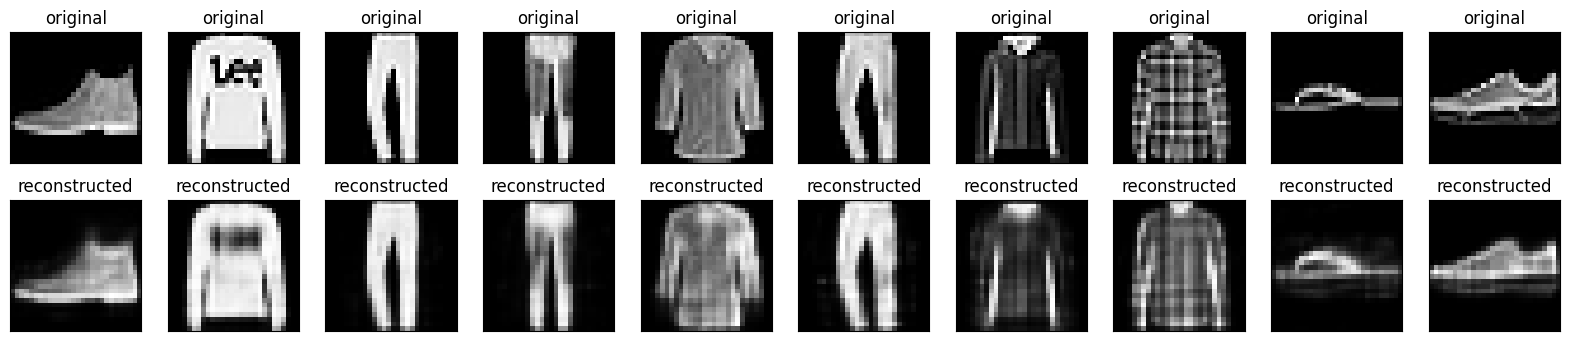

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## Second example: Image denoising


An autoencoder can also be trained to remove noise from images. In the following section, you will create a noisy version of the Fashion MNIST dataset by applying random noise to each image. You will then train an autoencoder using the noisy image as input, and the original image as the target.

Let's reimport the dataset to omit the modifications made earlier.

In [ ]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [ ]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


Adding random noise to the images

In [ ]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

Plot the noisy images.


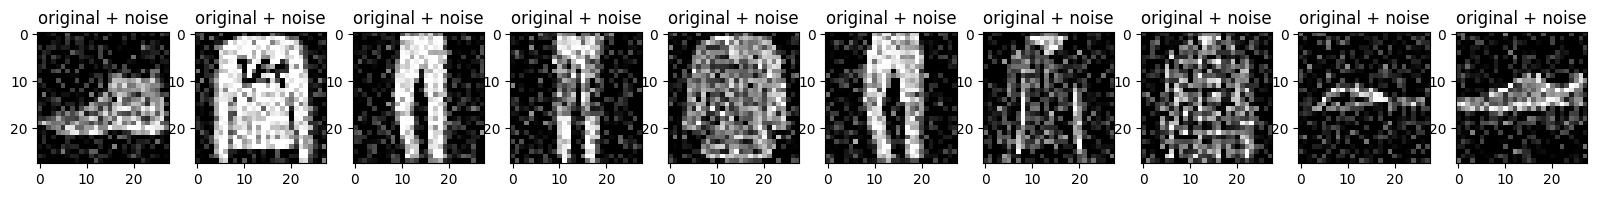

In [ ]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

### Define a convolutional autoencoder

In this example, you will train a convolutional autoencoder using  [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) layers in the `encoder`, and [Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) layers in the `decoder`.

In [ ]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 61s 32ms/step - loss: 0.0349 - val_loss: 0.0093
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 58s 31ms/step - loss: 0.0088 - val_loss: 0.0080
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 88s 35ms/step - loss: 0.0079 - val_loss: 0.0076
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 79s 33ms/step - loss: 0.0075 - val_loss: 0.0074
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 75s 29ms/step - loss: 0.0073 - val_loss: 0.0073
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 86s 31ms/step - loss: 0.0072 - val_loss: 0.0071
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 94s 38ms/step - loss: 0.0071 - val_loss: 0.0071
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 69s 37ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 72s 32ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 81s 31ms/step - loss: 0.0069 - val_loss: 0.0069


Let's take a look at a summary of the encoder. Notice how the images are downsampled from 28x28 to 7x7.

In [ ]:
autoencoder.encoder.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 7, 8)             │           1,160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,320 (5.16 KB)

 Trainable params: 1,320 (5.16 KB)

 Non-trainable params: 0 (0.00 B)

The decoder upsamples the images back from 7x7 to 28x28.

In [ ]:
autoencoder.decoder.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_transpose_2 (Conv2DTranspose) │ (32, 14, 14, 8)             │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (32, 28, 28, 16)            │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 28, 28, 1)             │             145 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,897 (7.41 KB)

 Trainable params: 1,897 (7.41 KB)

 Non-trainable params: 0 (0.00 B)

Plotting both the noisy images and the denoised images produced by the autoencoder.

In [ ]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

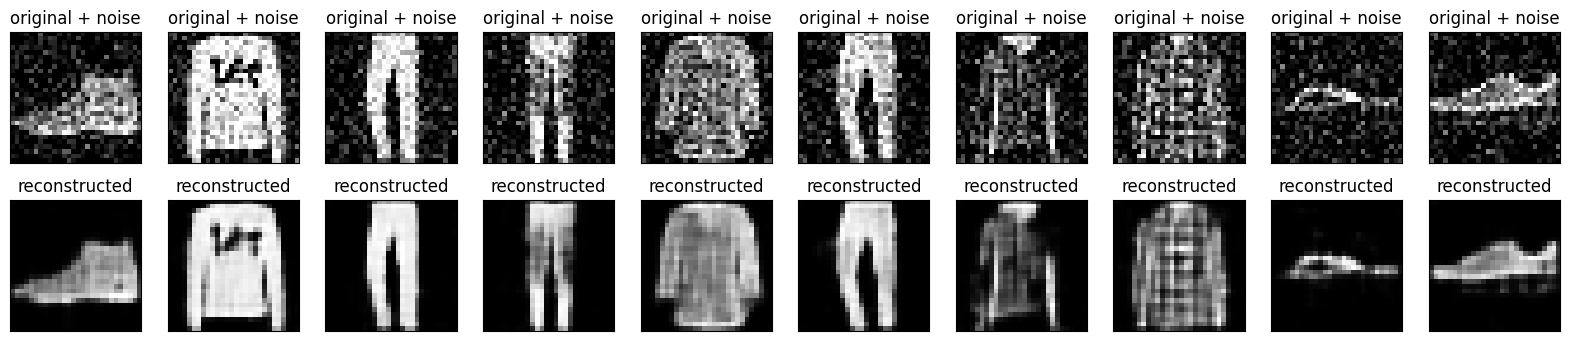

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()